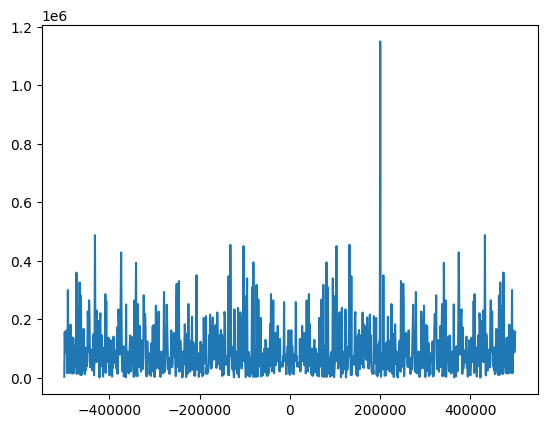

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from commstools import Signal

fs = 1e6  # 1 MHz sampling rate
f0 = 200e3  # 50 kHz tone
duration = 0.001  # 1 ms
t = np.arange(int(fs * duration)) / fs
samples = np.exp(1j * 2 * np.pi * f0 * t)

# add noise
noise = np.random.randn(len(samples))
samples += 10 * noise


sig = Signal(samples=samples, sampling_rate=fs)

freq, psd = sig.spectrum()

plt.plot(freq, psd)


In [ ]:
np.
